# Lucas Kanade - Basics
Load the Takeo image from the data directory using the auto importer.

In [4]:
%matplotlib inline
import numpy as np
np.set_printoptions(linewidth=500, precision=3)

import matplotlib.pyplot as plt
import menpo.io as mio

takeo = mio.import_builtin_asset('takeo.ppm')
takeo.view();

ImportError: cannot import name base

The Takeo image is grayscale, but still has three channels:

In [2]:
print(takeo.n_channels)
print(takeo.pixels.shape)

3
(3, 225, 150)


These are redundant. An easy way to remove them is to explicitly convert the image to greyscale

In [2]:
takeo = takeo.as_greyscale()
print(takeo.n_channels)
print(takeo.pixels.shape)
takeo.view();

NameError: name 'takeo' is not defined

Since Lucas-Kanade involves matching images between a template and an input, we begin by creating a template to match to. Therefore, we import a warping function and warp the original image to create a template. Create the warp involves defining a set of initial warp parameters, which we will attempt to recover using the Lucas-Kanade algorithm. The warp parameters are defined as the elements of the transform matrix that transforms from target to source. We honour the parameter layout specified in the Lucas-Kanade 20 years on paper:
\begin{pmatrix}
p_1 & p_3 & p_5\\
p_2 & p_4 & p_6
\end{pmatrix}

where $p_5$ and $p_6$ are the translation parameters.

Affine decomposing into:  
  CCW Rotation of 136.4 degrees about [0 0 1]
  NonUniformScale by [ 1.151  0.851]
  CCW Rotation of 133.6 degrees about [0 0 1]
  Translation by [ 70.  30.]
[[  1.    0.1  70. ]
 [  0.2   1.   30. ]
 [  0.    0.    1. ]]


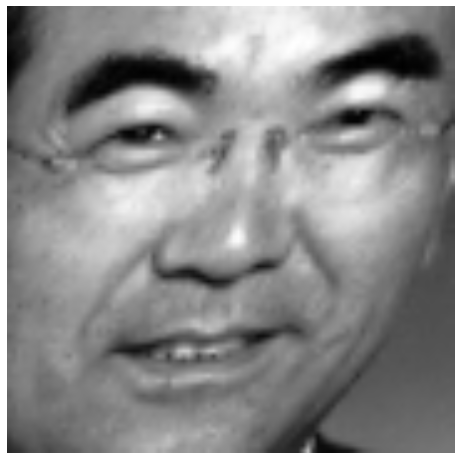

In [4]:
from menpofit.transform import DifferentiableAlignmentAffine
from menpo.transform import Affine
from menpo.image import BooleanImage

target_params = np.array([0, 0.2, 0.1, 0, 70, 30])
target_transform = Affine.init_identity(2).from_vector(target_params)
# printing an affine transform tells us what it does
print(target_transform)

# make a blank (default filled with 0's) greyscale (default: 1 channel) image to guide the warp
template = BooleanImage.init_blank((90, 90))

target = takeo.warp_to_mask(template, target_transform)
target.view();

In order to perform the alignment, we seperate the algorithm from the similarity measure used. Therefore, we begin by creating a similarity measure which defines how we define the error between the two images. For this example, we use the most simple case, the Sum of Squared (pixel) Differences (SSD).

In [5]:
from menpofit.lucaskanade.residual import SSD, ECC

residual = SSD()

Now, given an initial estimate, we can perform the alignment. We can either perform an inverse compositional alignment, or a forward additive. Lucas-Kanade is a gradient descent algorithm, and thus assumes a near global optimum initial parameterisaton. We therefore begin by initialising the image to roughly Takeo's face.

In [6]:
from menpo.shape import PointCloud

# Create the identity 'box' -> representing the area
# that the target image was warped into
corners = target.shape
identity_box = PointCloud(np.array([[0,          0],
                                    [corners[0], 0],
                                    [corners[0], corners[1]],
                                    [0,          corners[1]]]))

In [7]:
from menpofit.lucaskanade.image import IC, FA, FC
from copy import deepcopy

# Create the initial transform as an alignment transform
# so that we can get more interesting fitting information,
# since we then know the ground truth!
initial_params = np.array([0, 0, 0, 0, 70.5, 30.5])
inital_transform = Affine.init_identity(2).from_vector(initial_params)

# This is the initial 'box' that we are warping into
initial_box = inital_transform.apply(identity_box)
inital_transform = DifferentiableAlignmentAffine(identity_box, initial_box)

inv_comp = IC(target, residual, deepcopy(inital_transform))
for_add = FA(target, residual, deepcopy(inital_transform))
for_comp = FC(target, residual, deepcopy(inital_transform))

We then perform the alignment, and show the resulting transforms.

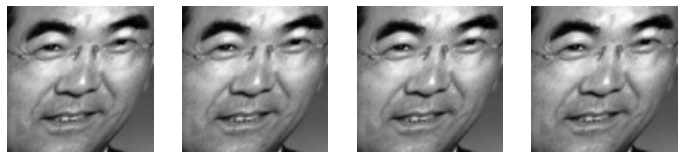

In [8]:
# Get Inverse Compositional optimum transform and plot
inv_comp_fitting = inv_comp.fit(takeo, initial_params)
inv_comp_res = takeo.warp_to_mask(template, inv_comp_fitting.final_transform)
plt.subplot(141)
inv_comp_res.view();

# Get Forward Compositional optimum transform and plot
for_comp_fitting = for_comp.fit(takeo, initial_params)
for_comp_res = takeo.warp_to_mask(template, for_comp_fitting.final_transform)
plt.subplot(142)
for_comp_res.view();

# Get Forward Additive optimum transform and plot
for_add_fitting = for_add.fit(takeo, initial_params)
for_add_res = takeo.warp_to_mask(template, for_add_fitting.final_transform)
plt.subplot(143)
for_add_res.view();

# Plot target image we were warping to
plt.subplot(144)
target.view();

# Set Figure to be larger
plt.gcf().set_size_inches(12.0, 5.0)

We can then compute the RMS point error between the original bounding box and the one proposed by our alignment algorithms. Usually, any error less than 3 pixels is considered a convergence.

In [9]:
# Create the target 'box' that the target was warped into
target_box = target_transform.apply(identity_box)

# Setup the fitting objects so we can generate useful results
inv_comp_fitting.error_type = 'rmse'
inv_comp_fitting.gt_shape = target_box
for_add_fitting.error_type = 'rmse'
for_add_fitting.gt_shape = target_box
for_comp_fitting.error_type = 'rmse'
for_comp_fitting.gt_shape = target_box

print('Inverse compositional RMS error: {0}'.format(inv_comp_fitting.final_error()))
print('Forward additive RMS error:      {0}'.format(for_add_fitting.final_error()))
print('Forward compositional RMS error: {0}'.format(for_comp_fitting.final_error()))

Inverse compositional RMS error: 1.85214965718e-07
Forward additive RMS error:      1.741351366e-07
Forward compositional RMS error: 4.81084344081e-07
